In [1]:
# %pip install numpy
# %pip install matplotlib
# %pip install matplotlib
# %pip install torch
# %pip install scikit-learn
# %pip install torchvision
# %pip install tqdm
# %pip install timm

In [2]:
# 1. Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torchvision.utils as vutils
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
from tqdm import tqdm
import torchvision.models as models
import timm

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 2. Path dataset
train_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/train/"
val_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/val/"
test_path = "/kaggle/input/fracture-bone-dataset/Bone_Fracture_Binary_Classification/test/"

In [4]:
# 3. Hàm lấy đường dẫn ảnh
def get_image_paths(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

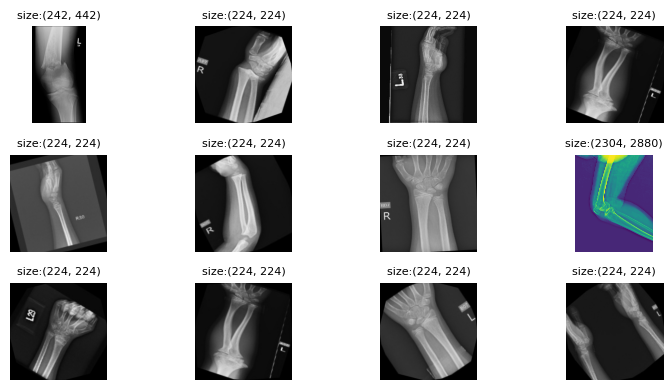

In [5]:
# 4. Hàm hiển thị dữ liệu
def display_dataset(path, num_images=12):
    random.seed(322)
    images_paths = get_image_paths(path)
    random_images = random.sample(images_paths, num_images)
    fig, axes = plt.subplots(3, 4, figsize=(8, 4))

    for i, ax in enumerate(axes.flat):
        image_path = random_images[i]
        image = Image.open(image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"size:{image.size}", fontsize=8)

    plt.tight_layout()
    plt.show()

display_dataset(val_path)

In [6]:
# 5. Xử lý hình ảnh RGBA, LA, P
class HandleTransparency(object):
    def __call__(self, img):
        if img.mode == 'RGBA' or img.mode == 'LA':
            img = img.convert('L')
        elif img.mode == 'P':
            img = img.convert('RGBA')
            img = img.convert('L')
        else:
            img = img.convert('L')
        return img

In [7]:
# 6. Transforms
train_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
    HandleTransparency(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [8]:
# 7. Load datasets
train_ds = ImageFolder(train_path, transform=train_transforms)
val_ds = ImageFolder(val_path, transform=val_transforms)

In [9]:
print(f"Số lượng lớp trong tập huấn luyện: {len(train_ds.classes)}")
print(f"Các lớp trong tập huấn luyện: {train_ds.classes}")
print(f"Số lượng lớp trong tập kiểm tra: {len(val_ds.classes)}")
print(f"Các lớp trong tập kiểm tra: {val_ds.classes}")

Số lượng lớp trong tập huấn luyện: 2
Các lớp trong tập huấn luyện: ['fractured', 'not fractured']
Số lượng lớp trong tập kiểm tra: 2
Các lớp trong tập kiểm tra: ['fractured', 'not fractured']


In [10]:
train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=64, shuffle=False)

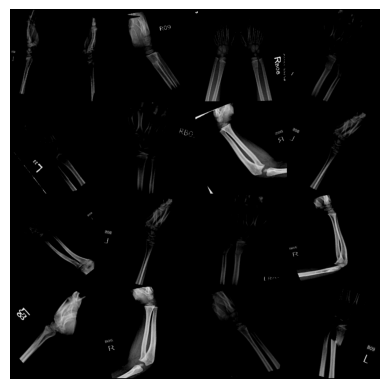

In [11]:
# 8. Xem thử batch ảnh
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

dataiter = iter(train_dataloader)
images, _ = next(dataiter)
imshow(vutils.make_grid(images[:16], nrow=4))

In [12]:
# 9. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# # 10. Định nghĩa ResNet Model
# class ResNetModel(nn.Module):
#     def __init__(self, num_classes):
#         super(ResNetModel, self).__init__()
#         self.model = models.resnet18(pretrained=True)
#         self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

#     def forward(self, x):
#         return self.model(x)

# num_classes = len(train_ds.classes)
# model = ResNetModel(num_classes=num_classes).to(device)

model = timm.create_model('resnet18.a1_in1k', pretrained=True, num_classes=2)

# 2. Freeze toàn bộ các tham số trước
for param in model.parameters():
    param.requires_grad = False

# 3. Chỉ fine-tune layer cuối (layer4) + classifier
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

# 4. Sửa lại Conv2d đầu vào nếu ảnh là grayscale (1 kênh)
out_channels = model.conv1.out_channels
kernel_size = model.conv1.kernel_size
stride = model.conv1.stride
padding = model.conv1.padding
bias = model.conv1.bias is not None

model.conv1 = nn.Conv2d(
    in_channels=1,
    out_channels=out_channels,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
    bias=bias
)

# 5. Move model to device
model = model.to(device)
# 6. Loss function, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [14]:
def train_one_epoch(model, train_dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    return avg_loss

In [15]:
def validate(model, val_dataloader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / len(val_dataloader.dataset)
    avg_loss = total_loss / len(val_dataloader)

    return avg_loss, accuracy, all_labels, all_predictions


In [16]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    accuracies = []
    all_labels = []
    all_predictions = []

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer)
        val_loss, accuracy, epoch_labels, epoch_predictions = validate(model, val_dataloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)

        all_labels.extend(epoch_labels)
        all_predictions.extend(epoch_predictions)

        scheduler.step()

        print(f'Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%')

    return train_losses, val_losses, accuracies, all_labels, all_predictions

In [17]:
train_losses, val_losses, accuracies, all_labels, all_predictions = train(
    model, train_dataloader, val_dataloader, criterion, optimizer, scheduler
)

 31%|███       | 4/13 [00:03<00:06,  1.33it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 13/13 [00:09<00:00,  1.39it/s]


Epoch: 1/20 | Train Loss: 0.6138 | Val Loss: 0.5313 | Accuracy: 81.30%


100%|██████████| 13/13 [00:07<00:00,  1.80it/s]


Epoch: 2/20 | Train Loss: 0.3624 | Val Loss: 0.3433 | Accuracy: 85.77%


100%|██████████| 13/13 [00:06<00:00,  1.94it/s]


Epoch: 3/20 | Train Loss: 0.1766 | Val Loss: 0.3177 | Accuracy: 85.28%


100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch: 4/20 | Train Loss: 0.0927 | Val Loss: 0.2081 | Accuracy: 91.44%


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch: 5/20 | Train Loss: 0.0568 | Val Loss: 0.1307 | Accuracy: 95.17%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch: 6/20 | Train Loss: 0.0452 | Val Loss: 0.1313 | Accuracy: 94.21%


100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch: 7/20 | Train Loss: 0.0357 | Val Loss: 0.1187 | Accuracy: 96.50%


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch: 8/20 | Train Loss: 0.0276 | Val Loss: 0.0954 | Accuracy: 96.38%


100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch: 9/20 | Train Loss: 0.0230 | Val Loss: 0.0785 | Accuracy: 97.95%


100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch: 10/20 | Train Loss: 0.0215 | Val Loss: 0.0685 | Accuracy: 98.19%


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch: 11/20 | Train Loss: 0.0184 | Val Loss: 0.0656 | Accuracy: 98.07%


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch: 12/20 | Train Loss: 0.0160 | Val Loss: 0.0661 | Accuracy: 97.83%


100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch: 13/20 | Train Loss: 0.0159 | Val Loss: 0.0602 | Accuracy: 98.19%


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch: 14/20 | Train Loss: 0.0146 | Val Loss: 0.0577 | Accuracy: 98.43%


100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch: 15/20 | Train Loss: 0.0141 | Val Loss: 0.0531 | Accuracy: 98.55%


100%|██████████| 13/13 [00:06<00:00,  1.92it/s]


Epoch: 16/20 | Train Loss: 0.0133 | Val Loss: 0.0530 | Accuracy: 98.55%


100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch: 17/20 | Train Loss: 0.0122 | Val Loss: 0.0497 | Accuracy: 98.79%


100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch: 18/20 | Train Loss: 0.0123 | Val Loss: 0.0475 | Accuracy: 98.79%


100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch: 19/20 | Train Loss: 0.0130 | Val Loss: 0.0525 | Accuracy: 98.43%


100%|██████████| 13/13 [00:07<00:00,  1.85it/s]

Epoch: 20/20 | Train Loss: 0.0118 | Val Loss: 0.0486 | Accuracy: 98.55%


In [18]:
import os

# Đường dẫn thư mục bạn muốn lưu
save_dir = 'FracturedDataResnet'

# Nếu thư mục chưa tồn tại thì tạo mới
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, 'model.pt')

torch.save(model.state_dict(), save_path)

print(f"Model đã được lưu tại {save_path}")


Model đã được lưu tại FracturedDataResnet/model.pt


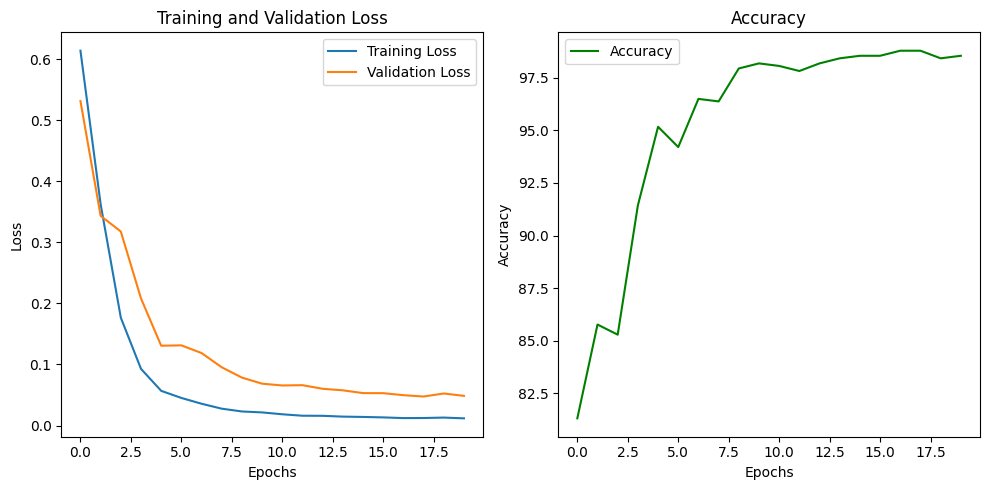

In [19]:
def plot_curves(train_losses, val_losses, accuracies):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_losses, accuracies)

In [20]:
def predict_image(image_path, model, transforms, device):
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)  # Thêm batch dimension

    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

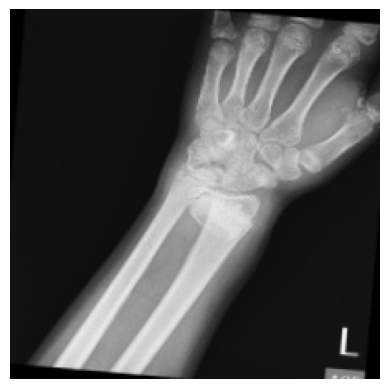

predict: 0 (fractured)
true label: fractured


In [21]:
image_path = random.choice(get_image_paths(test_path))
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.show()

predicted_class = predict_image(image_path, model, val_transforms, device)
true_class = image_path.split('/')[-2]

print(f"predict: {predicted_class} ({train_ds.classes[predicted_class]})")
print(f"true label: {true_class}")

In [22]:
test_transforms = v2.Compose([
    HandleTransparency(),
    v2.Grayscale(1),
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

test_ds = ImageFolder(test_path, transform=test_transforms)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [23]:
def measure_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    return accuracy

print(f"Validation Accuracy: {measure_accuracy(model, val_dataloader):.2f}%")
print(f"Test Accuracy: {measure_accuracy(model, test_dataloader):.2f}%")


Validation Accuracy: 98.55%
Test Accuracy: 49.41%
